# Computation of cutting planes: example 1

# The set-up

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy.special import expit # The logistic sigmoid function
import accpm
%load_ext autoreload
%autoreload 1
%aimport accpm

np.set_printoptions(precision=4)

$\DeclareMathOperator{\domain}{dom}
\newcommand{\transpose}{\text{T}}
\newcommand{\vec}[1]{\begin{pmatrix}#1\end{pmatrix}}$

# Example

To test the computation of cutting planes we consider a logistic regression problem. Particularly, we consider the problem of predicting the incidence of diabetes based on various measurements (see [description](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)). We use a normalised version of the data (which can be found at [mldata.org](http://mldata.org/repository/data/download/csv/diabetes_scale/)) where the label to be predicted (the incidence of diabetes) is in the first column. We have the following data processing:

In [2]:
names = ['diabetes', 'num preg', 'plasma', 'bp', 'skin fold', 'insulin', 'bmi', 'pedigree', 'age']
data = pd.read_csv('diabetes_scale.csv', header=None, names=names)
data['diabetes'].replace(-1, 0, inplace=True) # The target variable need be 1 or 0, not 1 or -1
data['ones'] = np.ones((data.shape[0], 1)) # Add a column of ones to represent the constant bias
data.head()

,diabetes,num preg,plasma,bp,skin fold,insulin,bmi,pedigree,age,ones
0,0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,1.0
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,0,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,1.0
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,0,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,1.0


In [3]:
np.random.seed(1)
size = data.shape[0]
index = np.arange(size)
np.random.shuffle(index)
training_index = index[:int(size/2)]
testing_index = index[int(size/2):]

In [4]:
Y = data['diabetes']
X = data[['num preg', 'plasma', 'bp', 'skin fold', 'insulin', 'bmi', 'pedigree', 'age', 'ones']]
X = np.array(X)
Y = np.array(Y)

In [5]:
X_training = X[training_index]
Y_training = Y[training_index]
X_testing = X[testing_index]
Y_testing = Y[testing_index]

This model has 9 input variables $x_0, \dots, x_8$ where $x_8$ is the dummy input variable fixed at 1. (The fixed dummy input variable could easily be $x_5$ or $x_7$, it's index is unimportant.) We set the basis functions to the simplest choice $\phi_0(\mathbf{x}) = x_0, \dots, \phi_8(\mathbf{x}) = x_8$. Our model then has the form
$$
  y(\mathbf{x}) = \sigma(\sum_{j=0}^{8} w_j x_j) = \sigma(\mathbf{w}^T \mathbf{x}.)
$$
Here we have a dataset, $\{(\mathbf{x}_n, t_n)\}_{n=0}^{N}$ where $t_n \in \{0, 1\}$, with $N + 1 =767 + 1 = 768$ examples. We train our model by finding the parameter vector $\mathbf{w}$ which minimizes the (data-dependent) cross-entropy error function
$$
  E_D(\mathbf{w}) =  - \sum_{n=0}^{N} \{t_n \ln \sigma(\mathbf{w}^T \mathbf{x}_n) + (1 - t_n)\ln(1 - \sigma(\mathbf{w}^T \mathbf{x}_n))\}.
$$
The gradient of this function is given by
$$
  \nabla E(\mathbf{w}) = \sum_{i=0}^{N} (\sigma(\mathbf{w}^T \mathbf{x}_n) - t_n)\mathbf{x}_n.
$$
We can then implement these as follows:

In [6]:
def cost(w, X, y, c=0):
    """
    Returns the cross-entropy error function with (optional) sum-of-squares regularization term.
    
    w -- parameters
    X -- dataset of features where each row corresponds to a single sample
    y -- dataset of labels where each row corresponds to a single sample
    c -- regularization coefficient (default = 0)
    """
    outputs = expit(X.dot(w)) # Vector of outputs (or predictions)
    return -( y.transpose().dot(np.log(outputs)) + (1-y).transpose().dot(np.log(1-outputs)) ) + c*0.5*w.dot(w)

def grad(w, X, y, c=0):
    """
    Returns the gradient of the cross-entropy error function with (optional) sum-of-squares regularization term.
    """
    outputs = expit(X.dot(w))
    return X.transpose().dot(outputs-y) + c*w
    
def train(X, y,c=0):
    """
    Returns the vector of parameters which minimizes the error function via the BFGS algorithm.
    """
    initial_values = np.zeros(X.shape[1]) # Error occurs if inital_values is set too high
    return opt.fmin_bfgs(cost, initial_values, fprime=grad, args=(X,y,c))

def predict(w, X):
    """
    Returns a vector of predictions. 
    """
    return expit(X.dot(w))

We test $\texttt{accpm}$ against the parameters attained using SciPy's $\texttt{fmin_bfgs}$ function via the $\texttt{train}$ function. The latter produces the following:

In [7]:
theta_best1 = train(X_training, Y_training)
print('---------------- Results ----------------')
print("The parameters attained using SciPy's fmin_bfgs are\n", theta_best1)
print('With these parameters the gradient is\n', grad(theta_best1, X_training, Y_training))
print('With these parameters the norm of the gradient is', np.linalg.norm(grad(theta_best1, X_training, Y_training)))

Optimization terminated successfully.
         Current function value: 175.645824
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28
---------------- Results ----------------
The parameters attained using SciPy's fmin_bfgs are
 [-1.3568 -4.0959  0.351  -0.4339  0.9395 -2.4337 -1.8708 -0.1914 -0.0497]
With these parameters the gradient is
 [ -3.7389e-07   1.0650e-07   4.6996e-08  -3.5702e-07  -5.5176e-07
  -4.4994e-08  -4.5631e-07  -3.5282e-07   7.3335e-07]
With these parameters the norm of the gradient is 1.20738543223e-06


We now compute the accuracy from the parameter vector attained using SciPy's $\texttt{fmin_bfgs}$

In [8]:
predictions_sp = predict(theta_best1, X_testing).round()
results_sp = predictions_sp == Y_testing
correct_sp = np.count_nonzero(results_sp)
accuracy_sp = correct_sp/X_testing.shape[0]
print(accuracy_sp)

0.765625


The former gives the following where we take the initial polyhedron to be the 9-dimensional cube centered at the origin with side length 20:

In [10]:
A = []
b = []
for i in range(X.shape[1]):
    a_upper = [0]*X.shape[1]
    a_lower = [0]*X.shape[1]
    a_upper[i] = 1
    a_lower[i] = -1
    A.append(a_upper)
    A.append(a_lower)
    b.append(10)
    b.append(10)

A = np.array(A, dtype = accpm.myfloat)
b = np.array(b, dtype = accpm.myfloat)

theta_best2 = accpm.accpm(A, b, cost, grad, args = (X_training, Y_training),
                          alpha=0.01, beta=0.7, start=1, maxiter = 300, 
                          summary=1, testing=1)[1]


-------- Starting ACCPM --------
Initially: b = [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.] and A =
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]]
--------------------------------
Entering iteration 0
At iteration 0 AC computation SUCCEEDED with AC [ 0.  0.  0.  0.  0.  0.  0.  0.  0.] where
 

In [11]:
A = []
b = []
for i in range(X.shape[1]):
    a_upper = [0]*X.shape[1]
    a_lower = [0]*X.shape[1]
    a_upper[i] = 1
    a_lower[i] = -1
    A.append(a_upper)
    A.append(a_lower)
    b.append(10)
    b.append(10)

A = np.array(A, dtype = accpm.myfloat)
b = np.array(b, dtype = accpm.myfloat)

theta_all = accpm.accpm(A, b, cost, grad, args = (X_training, Y_training),
                          alpha=0.01, beta=0.7, start=1, maxiter = 300, 
                          summary=1, testing=3)[2]


-------- Starting ACCPM --------
Initially: b = [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.] and A =
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]]
--------------------------------
Entering iteration 0
Entering iteration 1
Entering iteration 2
Entering iteration 3
Entering iteration 4
Entering 

In [12]:
np.array(theta_all).shape

(140, 9)

In [13]:
print(theta_all)

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([-2.6527, -1.0517, -0.0934, -2.1917, -2.7985, -0.8977, -2.6536,
       -2.9045,  3.0371]), array([-4.1322, -0.7374,  0.0726, -2.1675, -2.0407, -0.3869, -1.0317,
       -0.5889,  0.0746]), array([-5.1155, -0.4555,  0.219 , -2.1355, -1.468 , -0.0616,  0.0909,
        0.9203, -1.8211]), array([-7.2136, -2.0243,  0.5725, -4.5855, -2.7293,  0.6718,  2.4822,
        3.8895, -4.7483]), array([-0.1337, -6.8949, -3.5352,  1.982 ,  1.7676, -4.2284, -3.8922,
       -4.6877, -2.8607]), array([ 0.6099, -2.6154, -1.0494,  0.481 , -0.1449, -1.2843, -2.1486,
       -1.9096, -0.1688]), array([-3.1047, -7.4201,  0.9824, -1.3044,  1.8606, -5.2626, -3.8582,
       -1.0578, -2.3476]), array([-0.4838, -7.1577,  1.9407, -1.1393,  1.3351, -4.699 , -4.6118,
        2.655 ,  0.396 ]), array([-3.5862, -6.8179,  1.5597,  1.3079,  3.1396, -3.2426, -3.0259,
       -0.2867,  1.5765]), array([-1.7247, -6.7868, -1.5117, -2.7301,  0.8087, -3.978 , -1.4022,
  

The algorithm converged in 140 iterations and we observe that 

In [14]:
difference = np.abs(theta_all[1]-theta_best2)
print("The absolute element wise difference between the parameters attained via SciPy's", 
      "fmin_bfgs function and the ACCPM are\n", difference)
print("The norm value of this difference is", np.linalg.norm(difference))

The absolute element wise difference between the parameters attained via SciPy's fmin_bfgs function and the ACCPM are
 [ 1.2953  3.0448  0.4447  1.7577  3.7383  1.5351  0.7822  2.7139  3.0867]
The norm value of this difference is 6.93339259879


and so the results of the two functions are comparable. 

Indeed, having gathered the parameter collected at each iteration we can see how the accuracy improved over time

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
theta_all = np.array(theta_all)
queries = np.arange(1, theta_all.shape[0] + 1)
accuracies = []

for i in range(theta_all.shape[0]):
    predictions = predict(theta_all[i], X_testing).round()
    results = predictions == Y_testing
    correct = np.count_nonzero(results)
    accuracy = correct/X_testing.shape[0]
    accuracies.append(accuracy)

accuracies = np.array(accuracies)

In [17]:
accuracies[-1]

0.765625

In [18]:
accuracies.shape

(140,)

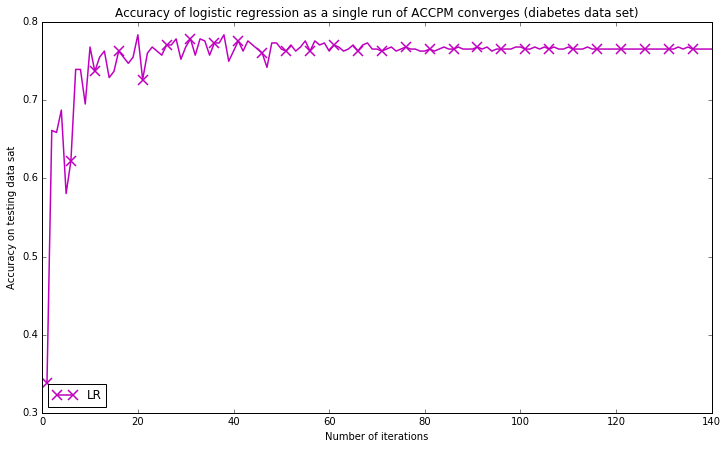

In [19]:
plt.figure(figsize=(12,7))

plt.plot(queries, accuracies, 'mx-', label='LR', 
         markevery=5,
         lw=1.5, ms=10, markerfacecolor='none', markeredgewidth=1.5,
         markeredgecolor = 'm')

plt.xlabel('Number of iterations')
plt.ylabel('Accuracy on testing data sat')
plt.title('Accuracy of logistic regression as a single run of ACCPM converges (diabetes data set)')
plt.legend(loc='best')

plt.savefig('accpm_experiment.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

Below we run some more tests and observe that the algorithm converges for smaller initial polyhedrons but fails entirely for larger polyhedrons.

In [22]:
A = []
b = []
for i in range(X.shape[1]):
    a_upper = [0]*X.shape[1]
    a_lower = [0]*X.shape[1]
    a_upper[i] = 1
    a_lower[i] = -1
    A.append(a_upper)
    A.append(a_lower)
    b.append(5)
    b.append(5)

A = np.array(A, dtype = accpm.myfloat)
b = np.array(b, dtype = accpm.myfloat)

theta_best3 = accpm.accpm(A, b, cost, grad, args = (X, Y),
                          alpha=0.01, beta=0.7, start=1, maxiter = 300, 
                          summary=1, testing=1)[1]

-------- Starting ACCPM --------
Initially: b = [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.] and A =
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]]
--------------------------------
Entering iteration 0
At iteration 0 AC computation SUCCEEDED with AC [ 0.  0.  0.  0.  0.  0.  0.  0.  0.] where
        a_cp = [ 0.3

In [23]:
A = []
b = []
for i in range(X.shape[1]):
    a_upper = [0]*X.shape[1]
    a_lower = [0]*X.shape[1]
    a_lower[i] = -1
    A.append(a_upper)
    A.append(a_lower)
    b.append(20)
    b.append(20)

A = np.array(A, dtype = accpm.myfloat)
b = np.array(b, dtype = accpm.myfloat)

theta_best4 = accpm.accpm(A, b, cost, grad, args = (X, Y),
                          alpha=0.01, beta=0.7, start=1, maxiter = 300, 
                          summary=1, testing=1)[1]


-------- Starting ACCPM --------
Initially: b = [ inf  20.  inf  20.  inf  20.  inf  20.  inf  20.  inf  20.  inf  20.  inf
  20.  inf  20.] and A =
 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.  -1.   0.   0.   0.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.  -1.   0.   0.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.   0.  -1.   0.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.   0.   0.  -1.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.   0.   0.   0.  -1.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.   0.   0.   0.   0.  -1.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.   0.   0.   0.   0.   0.  -1.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.   0.   0.   0.   0.   

ValueError: array must not contain infs or NaNs

In [24]:
A = []
b = []
for i in range(X.shape[1]):
    a_upper = [0]*X.shape[1]
    a_lower = [0]*X.shape[1]
    a_upper[i] = 1
    a_lower[i] = -1
    A.append(a_upper)
    A.append(a_lower)
    b.append(20)
    b.append(20)

A = np.array(A, dtype = accpm.myfloat)
b = np.array(b, dtype = accpm.myfloat)

theta_best5 = accpm.accpm(A, b, cost, grad, args = (X, Y),
                          alpha=0.01, beta=0.7, start=1, maxiter = 300, 
                          summary=1, testing=1)[1]


-------- Starting ACCPM --------
Initially: b = [ 20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.
  20.  20.  20.] and A =
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]]
--------------------------------
Entering iteration 0
At iteration 0 AC computation SUCCEEDED with AC [ 0.  0.  0.  0.  0.  0.  0.  0.  0.] where
 

ValueError: array must not contain infs or NaNs